In [1]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz (14.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


In [2]:
from ingest_data import fetch_data
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm.auto import tqdm
import swifter

c:\Users\satis\OneDrive\Desktop\MiniProjectsem_7\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_name = "louisbrulenaudet/clinical-trials"
ds = fetch_data(dataset_name)

Saving the dataset (8/8 shards): 100%|██████████| 541897/541897 [00:15<00:00, 34372.56 examples/s]


In [4]:
tqdm.pandas(desc="Segmenting Criteria")

In [5]:
try:
    nlp = spacy.load("en_core_sci_sm")
except OSError:
    print("Error")

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['nct_id', 'updated_at', 'brief_title', 'official_title', 'acronym', 'study_type', 'overall_status', 'study_first_submit_date', 'start_date', 'primary_completion_date', 'completion_date', 'phases', 'enrollment_count', 'minimum_age', 'maximum_age', 'sex', 'healthy_volunteers', 'brief_summary', 'detailed_description', 'eligibility_criteria', 'lead_sponsor_name', 'lead_sponsor_class', 'org_study_id_info', 'why_stopped', 'expanded_access_info', 'last_update_submit_qc_date', 'last_update_post_date_struct', 'study_first_post_date_struct', 'std_ages', 'study_population', 'sampling_method', 'oversight_has_dmc', 'design_info', 'conditions', 'keywords', 'interventions', 'locations', 'collaborators', 'arm_groups', 'outcomes', 'overall_officials', 'study_references', 'misc_info_module', 'condition_browse_module', 'intervention_browse_module', 'mesh_terms'],
        num_rows: 541897
    })
})

In [7]:
split = ds['train'].train_test_split(test_size=0.1, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['nct_id', 'updated_at', 'brief_title', 'official_title', 'acronym', 'study_type', 'overall_status', 'study_first_submit_date', 'start_date', 'primary_completion_date', 'completion_date', 'phases', 'enrollment_count', 'minimum_age', 'maximum_age', 'sex', 'healthy_volunteers', 'brief_summary', 'detailed_description', 'eligibility_criteria', 'lead_sponsor_name', 'lead_sponsor_class', 'org_study_id_info', 'why_stopped', 'expanded_access_info', 'last_update_submit_qc_date', 'last_update_post_date_struct', 'study_first_post_date_struct', 'std_ages', 'study_population', 'sampling_method', 'oversight_has_dmc', 'design_info', 'conditions', 'keywords', 'interventions', 'locations', 'collaborators', 'arm_groups', 'outcomes', 'overall_officials', 'study_references', 'misc_info_module', 'condition_browse_module', 'intervention_browse_module', 'mesh_terms'],
        num_rows: 487707
    })
    test: Dataset({
        features: ['nct_id', 'updated

In [8]:
COLUMNS_TO_KEEP = [
    'nct_id', 'eligibility_criteria', 'overall_status', 'phases', 'study_type',
    'minimum_age', 'maximum_age', 'sex', 'healthy_volunteers', 'conditions',
    'keywords', 'interventions', 'mesh_terms', 'locations', 'brief_title',
    'official_title', 'brief_summary'
]

In [9]:
df=split["train"].to_pandas()
df=df[COLUMNS_TO_KEEP]
df.dropna(subset=['eligibility_criteria'], inplace=True)

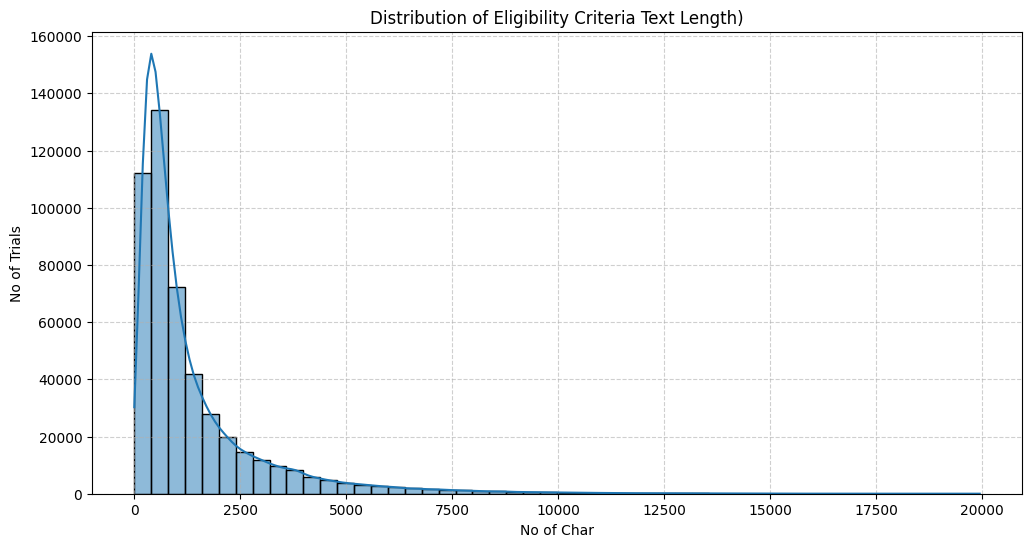

In [10]:
df['criteria_length'] = df['eligibility_criteria'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(df['criteria_length'].dropna(), bins=50, kde=True)
plt.title('Distribution of Eligibility Criteria Text Length)')
plt.xlabel('No of Char')
plt.ylabel('No of Trials')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [11]:
def segment_criteria(texts: list[str]) -> list[list[str]]:
    results = []
    for doc in nlp.pipe(texts, batch_size=100, n_process=4):
        segmented_criteria = []
        for sent in doc.sents:
            cleaned_sent = sent.text.strip()
            if len(cleaned_sent) > 10:
                segmented_criteria.append(cleaned_sent)
        results.append(segmented_criteria)
    return results

In [12]:
df["eligibility_criteria_clean"] = (
    df["eligibility_criteria"]
    .fillna("")
    .str.replace("•", "\n-")
    .str.replace("*", "\n-")
)

In [13]:
df["segmented_criteria"] = segment_criteria(df["eligibility_criteria_clean"].tolist())
df['segmented_criteria'].head()

0    [Inclusion Criteria:\n\n\n- University student...
1    [Inclusion Criteria:\n\n1. ≥18years old\n2., H...
2    [Inclusion Criteria:\n\n\n- Sleep complaints\n...
3    [Inclusion Criteria for participants:\n\n\n- P...
4    [Inclusion Criteria:\n\n\n- Subjects must have...
Name: segmented_criteria, dtype: object

In [ ]:
df.to_csv("../data/pro/train.csv")
df=split["test"].to_pandas()
df.to_csv("../data/pro/test.csv")